In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, MaxPooling2D

In [2]:
# #fetch Images from directory
# dirs = os.listdir('train/')
# for dir in dirs:
#     files = list(os.listdir('train/' + dir))
#     print(f'There are {len(files)} images of {dir}')

In [ ]:
# Delete corrupted images  
num_skipped = 0
dirs = os.listdir('train/')
for dir in dirs:
    files = os.listdir('train/' + dir)
    for file in files:
        fpath = os.path.join('train/',dir, file)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


In [4]:
base_dir = 'train/'
img_size = 180
batch_size = 32

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(base_dir, 
                                                        validation_split=0.2,
                                                        subset="training",
                                                        seed=123,                                                        
                                                        batch_size=batch_size,
                                                        image_size =(img_size, img_size)
                                                        )
 
val_ds = tf.keras.utils.image_dataset_from_directory(base_dir, 
                                                        validation_split=0.2,
                                                        subset="validation",
                                                        seed=123,                                                       
                                                        batch_size=batch_size,
                                                        image_size = (img_size, img_size)
                                                        )   

Found 2740 files belonging to 5 classes.
Using 2192 files for training.
Found 2740 files belonging to 5 classes.
Using 548 files for validation.


In [6]:
flower_names = train_ds.class_names
print(flower_names)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [7]:
import matplotlib.pyplot as plt

In [8]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

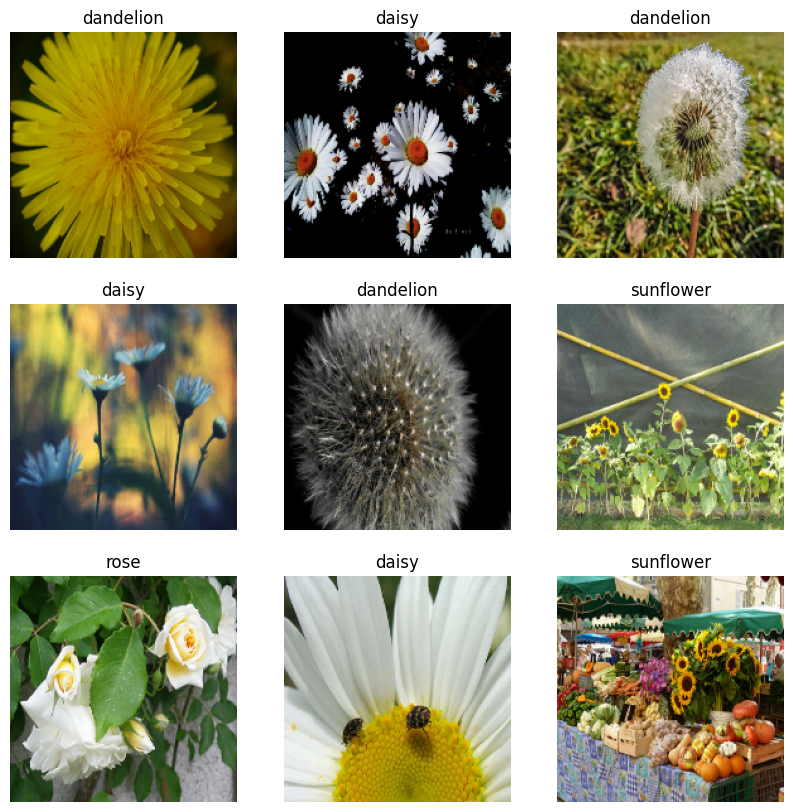

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(flower_names[labels[i]])
        plt.axis("off") 

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

In [11]:
train_ds =  train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [12]:
val_ds =  val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
#Data augmentation

In [14]:
data_augmentation = Sequential([
        layers.RandomFlip("horizontal", input_shape=(img_size, img_size,3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
])

d:\Flower_dataset\.venv\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
type(data_augmentation)

keras.src.models.sequential.Sequential

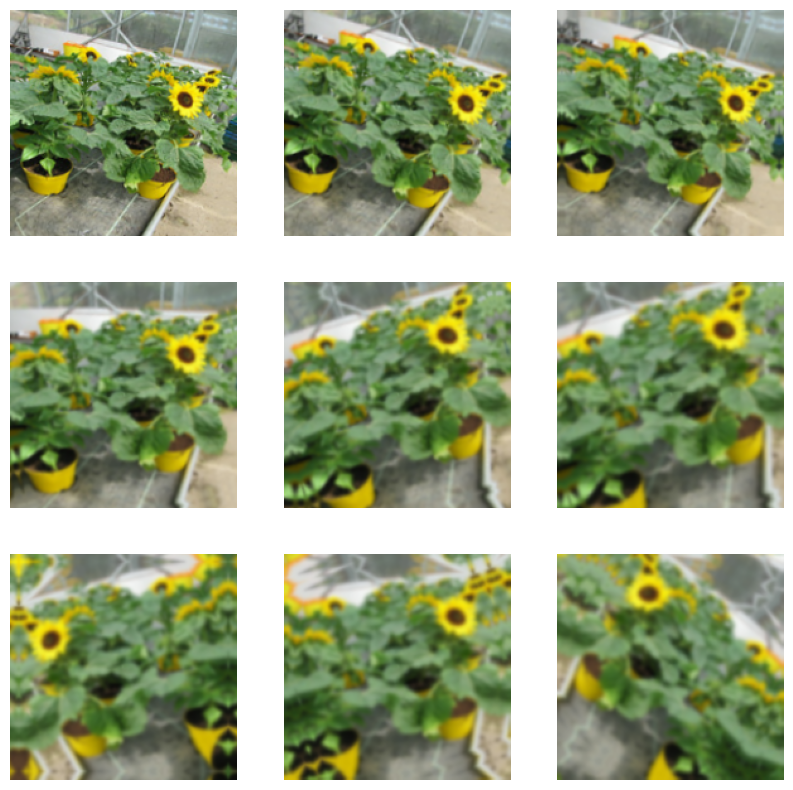

In [16]:
i = 0
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off") 

Model Creation

In [17]:
# why do we have to rescale? other parameters?
model =  Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
    ]
)

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy']
                )

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15


69/69 ━━━━━━━━━━━━━━━━━━━━ 33s 409ms/step - accuracy: 0.3764 - loss: 1.4198 - val_accuracy: 0.4854 - val_loss: 1.2630
Epoch 2/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 27s 392ms/step - accuracy: 0.5406 - loss: 1.1091 - val_accuracy: 0.5109 - val_loss: 1.1857
Epoch 3/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 25s 363ms/step - accuracy: 0.6163 - loss: 0.9954 - val_accuracy: 0.5657 - val_loss: 1.0834
Epoch 4/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 24s 341ms/step - accuracy: 0.6629 - loss: 0.9023 - val_accuracy: 0.5748 - val_loss: 1.0850
Epoch 5/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 23s 335ms/step - accuracy: 0.6752 - loss: 0.8375 - val_accuracy: 0.6277 - val_loss: 0.9609
Epoch 6/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 23s 336ms/step - accuracy: 0.7012 - loss: 0.7752 - val_accuracy: 0.6241 - val_loss: 0.9586
Epoch 7/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 23s 325ms/step - accuracy: 0.7044 - loss: 0.7298 - val_accuracy: 0.6442 - val_loss: 0.9689
Epoch 8/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 26s 382ms/step - accuracy: 0.7135 - loss: 0.7208 - val_accuracy: 0.658

In [21]:
def classify_flower(image_path):
    input_img = tf.keras.utils.load_img(image_path, target_size=(img_size, img_size))
    input_image_array = tf.keras.utils.img_to_array(input_img)
    input_image_exp_dim = tf.expand_dims(input_image_array, axis=0)
    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    output = ' The Imnage is of type: ' + flower_names[np.argmax(result)] + 'with a score of ' + str(max(result)*100)
    return output

np.int64(3)

In [22]:
import pickle

In [23]:
output_file = 'flower_names=%s.bin' 
output_file

'flower_names=%s.bin'

In [24]:
with open('flower_names.bin', 'wb') as f_out:
    pickle.dump(model, f_out)

In [25]:
with open('flower_names.bin', 'rb') as f_in:
    model = pickle.load(f_in)

In [26]:
model

<Sequential name=sequential_1, built=True>

In [27]:
input_img = tf.keras.utils.load_img("test\Image_1.jpg", target_size=(img_size, img_size))
input_image_array = tf.keras.utils.img_to_array(input_img)
input_image_exp_dim = tf.expand_dims(input_image_array, axis=0)
predictions = model.predict(input_image_exp_dim)
result = tf.nn.softmax(predictions[0])
output = ' The Imnage is of type: ' + flower_names[np.argmax(result)] + 'with a score of ' + str(max(result)*100)

<>:1: SyntaxWarning: invalid escape sequence '\I'
<>:1: SyntaxWarning: invalid escape sequence '\I'
C:\Users\Dung\AppData\Local\Temp\ipykernel_16924\1515398922.py:1: SyntaxWarning: invalid escape sequence '\I'
  input_img = tf.keras.utils.load_img("test\Image_1.jpg", target_size=(img_size, img_size))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


In [28]:
output

' The Imnage is of type: sunflowerwith a score of tf.Tensor(99.931206, shape=(), dtype=float32)'